In [200]:
import IPython.core.display
import matplotlib

def apply_styles():
    matplotlib.rcParams['font.size'] = 12
    matplotlib.rcParams['figure.figsize'] = (18, 6)
    matplotlib.rcParams['lines.linewidth'] = 1
apply_styles()

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="ticks")
import warnings
warnings.filterwarnings('ignore')


from sklearn.preprocessing import scale, PolynomialFeatures
import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix, classification_report, precision_score

In [201]:
#Load data
df = pd.read_csv("../Data/radar.csv", header=None,  names=['time','x','y','z'])#,index_col=0)
df.head(5)
df.describe()
# df

,time,x,y,z
count,130.000000,130.000000,130.000000,130.000000
mean,645.000000,3461.523077,3238.405231,10737.692308
std,376.718286,1858.352781,1741.221296,4156.621418
min,0.000000,48.800000,8.480000,2590.000000
25%,322.500000,1912.500000,1820.000000,7267.500000
50%,645.000000,3555.000000,3340.000000,11250.000000
75%,967.500000,5115.000000,4732.500000,14300.000000
max,1290.000000,6370.000000,5970.000000,17000.000000


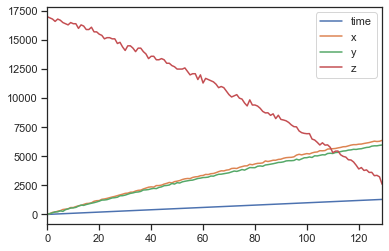

In [202]:
df.plot() #x grows faster than y, z has some random variances

In [203]:
df_buildings = pd.read_csv("../Data/mbuildings.csv")
df_buildings.head(5)
df_buildings.describe() #we can see there are missing residents

,residents,bed,bath,x,y
count,1656.000000,2417.000000,2417.000000,2417.000000,2417.000000
mean,2.175725,2.283409,2.103020,7158.813206,6650.869640
std,1.296489,1.200659,1.233391,69.128844,68.081989
min,0.000000,1.000000,1.000000,7024.160000,6514.160000
25%,1.000000,1.000000,1.000000,7101.760000,6597.360000
50%,2.000000,2.000000,2.000000,7157.280000,6650.000000
75%,3.000000,3.000000,3.000000,7215.360000,6705.360000
max,7.000000,9.000000,9.000000,7295.840000,6785.840000


Q1 (20). Using (any) methods you learned in this (wonderful) class estimate the expected point of impact. The
impact is obviously determined when altitude of the meteorite is 0.

## Ideas
- Predict phisics, aka. velocity, acceleration & direction.
    - Problem? What if there is wind or some other force we dont account for.
- Use different predictors that have biger memory for multiple hidden variables.

-get x & y variance, then predict the one with the least variance, use another model with the predicted variable as input too to predict the other coordinate

Polynomial regression

   

In [204]:
#Split data
from sklearn.model_selection import train_test_split
X = df[['z']].as_matrix()
y = df.x
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=True)

In [205]:
regr = skl_lm.LinearRegression()

regr.fit(X_train,y_train)

print(regr.coef_)
print(regr.intercept_)
y_pred = regr.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("R^2: {}".format(regr.score(X_test, y_test)))
print("Root Mean Squared Error: {}".format(rmse))

[-0.44152551]
8197.319657838381
R^2: 0.9801654593380923
Root Mean Squared Error: 258.95083390621045


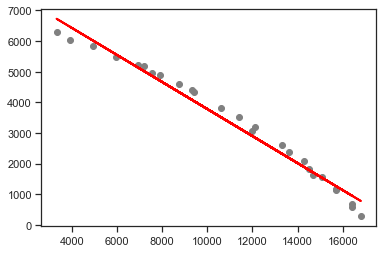

In [206]:
plt.scatter(X_test, y_test,  color='gray')
plt.plot(X_test, y_pred, color='red', linewidth=2)
plt.show()

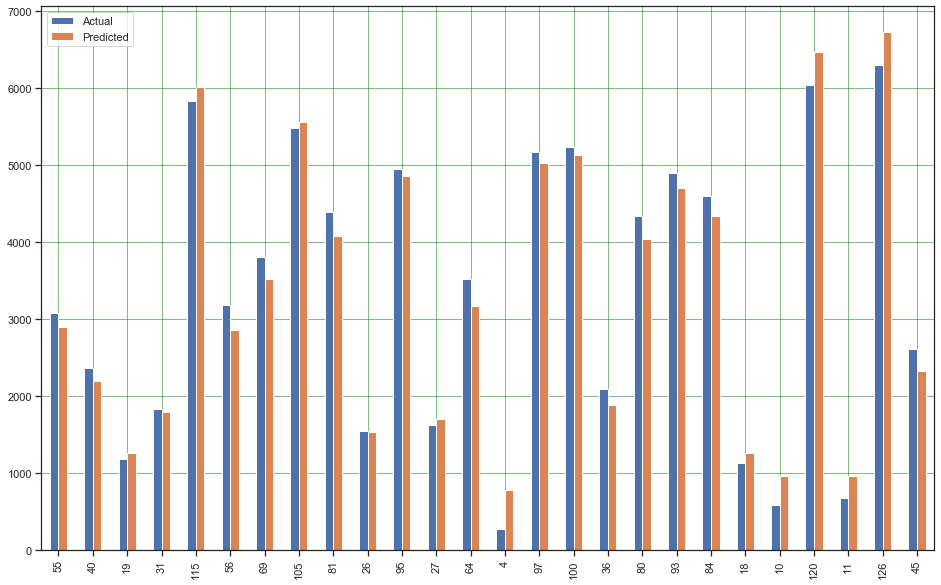

In [207]:
df_pred =  pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
# df_pred = df_pred.head(25)
df_pred.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [208]:
regr.predict([[0]])

array([8197.31965784])

96.50964064415912
0.9972873149091951


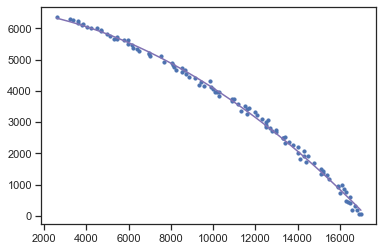

80.16832304227113
0.9980989518461866


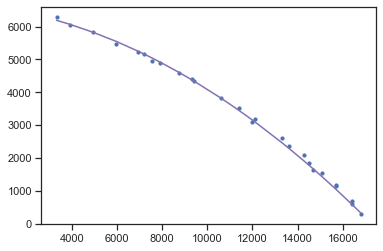

In [213]:
from sklearn.preprocessing import PolynomialFeatures
import operator
polynomial_features= PolynomialFeatures(degree=2)
x_poly = polynomial_features.fit_transform(X_train)

model = skl_lm.LinearRegression()
model.fit(x_poly, y_train)
y_poly_pred = model.predict(x_poly)

rmse = np.sqrt(mean_squared_error(y_train,y_poly_pred))
r2 = r2_score(y_train,y_poly_pred)
print(rmse)
print(r2)

plt.scatter(X_train, y_train, s=10)
# sort the values of x before line plot
sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(X_train,y_poly_pred), key=sort_axis)
X_train_pol, y_poly_pred = zip(*sorted_zip)
plt.plot(X_train_pol, y_poly_pred, color='m')
plt.show()

#######################################################
#######################################################
##Test
x_test_poly = polynomial_features.fit_transform(X_test)
y_poly_pred = model.predict(x_test_poly)

rmse = np.sqrt(mean_squared_error(y_test,y_poly_pred))
r2 = r2_score(y_test,y_poly_pred)
print(rmse)
print(r2)

plt.scatter(X_test, y_test, s=10)
# sort the values of x before line plot
sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(X_test,y_poly_pred), key=sort_axis)
X_test_pol, y_poly_pred = zip(*sorted_zip)
plt.plot(X_test_pol, y_poly_pred, color='m')
plt.show()
print( model.predict(0))